# Optimizing AI Trading Algorithms - Final Project

In this project we focus on optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate and practice the concepts covered in the course, such as data pre-processing, hyperparameter tuning, detecting and addressing over-/under-fitting, regularization techniques, model evaluation, and drift detection techniques.


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score, roc_curve

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

## 1. Data Exploration, Cleaning and Preprocessing


It is widely believed that the Utilities, Consumer Staples and Healthcare sectors are relatively more resilient to recessions and many stock market investors flock to these sectors in times of uncertainty. In this project, we will use daily OHLCV data for the [SPDR Healthcase Sector ETF](https://www.sectorspdrs.com/mainfund/XLV), a market volatility index, as well as monthly [Google search trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the word "recession" in the United States to try and predict whether the price of the Health Care Select Sector SPDR Fund [(NYSEARCA: XLV)
](https://finance.yahoo.com/quote/XLV) is going to increase or decrease over the next 5 trading days.


In [2]:
ohlcv_data = yf.download("XLV", start="2004-01-01", end="2024-03-31", interval="1d")
data = ohlcv_data.copy()

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2004-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5094 non-null   float64
 1   High       5094 non-null   float64
 2   Low        5094 non-null   float64
 3   Close      5094 non-null   float64
 4   Adj Close  5094 non-null   float64
 5   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 278.6 KB


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,65.342311,65.730397,64.924197,65.349097,58.242299,7.228951e+06
std,36.695351,36.915853,36.477869,36.712468,37.932219,5.445803e+06
min,22.010000,22.290001,21.629999,21.879999,16.812485,5.870000e+04
25%,31.990000,32.132501,31.812500,31.990000,24.508564,3.790550e+06
50%,57.100000,57.400000,56.680000,57.010000,48.387007,6.582850e+06
75%,90.657503,91.077497,89.927500,90.557499,82.941324,9.559550e+06
max,147.919998,148.270004,147.679993,147.860001,147.729996,6.647020e+07


In [5]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,145.850006,146.220001,145.259995,145.440002,145.440002,5537200
2024-03-25,145.710007,145.860001,145.009995,145.240005,145.240005,5253000
2024-03-26,145.529999,145.940002,145.139999,145.770004,145.770004,6942400
2024-03-27,147.009995,147.710007,146.619995,147.710007,147.710007,8797400
2024-03-28,147.919998,148.229996,147.679993,147.729996,147.729996,8090200


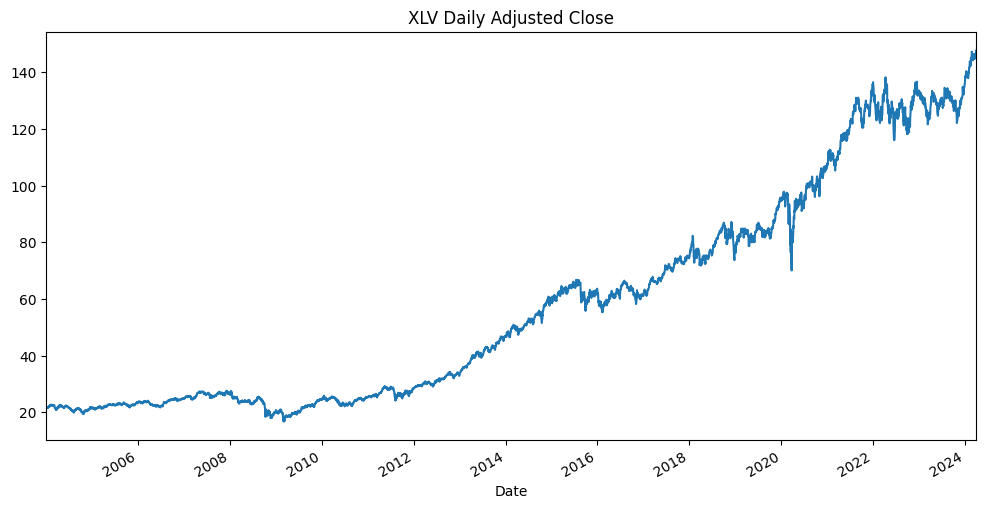

In [7]:
# Plot the adjusted close price using matplotlib
data["Adj Close"].plot.line(title="XLV Daily Adjusted Close", figsize=(12, 6))
plt.xlim(data.index[0], data.index[-1])

# Display the plot
plt.show()

In [8]:
data_since_2023 = data["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

In [9]:
# Create categorical features for the month and day of the week
data["Month"] = data.index.month
data["Weekday"] = data.index.weekday

In [10]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_windows = [1, 5, 10, 20]
for window in hist_ret_windows:
    data[f"ret_{window}d_hist"] = data["Adj Close"] / data["Adj Close"].shift(window) - 1

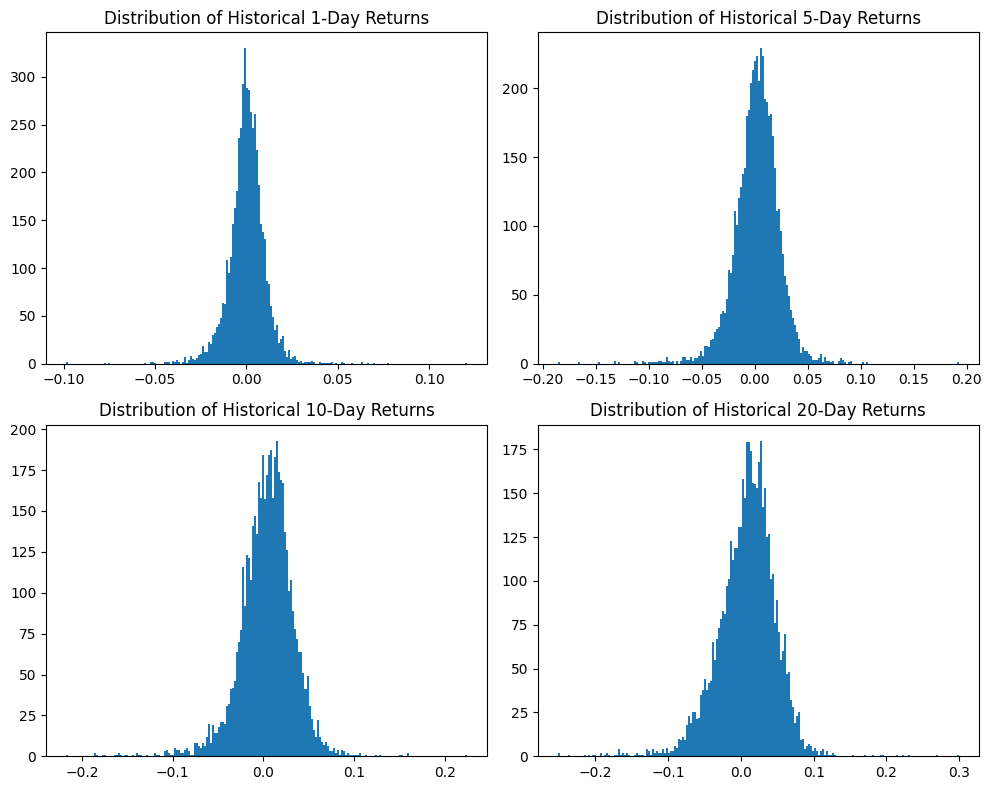

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

def plot_hist_returns(ax, data, col, title):
    ax.hist(data[col], bins=200)
    ax.set_title(title)

for i, window in enumerate(hist_ret_windows):
    plot_hist_returns(axs[i // 2, i % 2], data, f"ret_{window}d_hist", f"Distribution of Historical {window}-Day Returns")

plt.tight_layout()
plt.show()

In [12]:
# Create prediction target variables for future 5-day return
data["tgt_ret_5d_fut"] = data["Adj Close"].shift(-5) / data["Adj Close"] - 1
data["tgt_is_pos_ret_5d_fut"] = (data["tgt_ret_5d_fut"] > 0).astype(int)

In [13]:
# Inspect the distribution of the target variable
target_value_counts = data["tgt_is_pos_ret_5d_fut"].value_counts()
target_value_counts / len(data)

tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

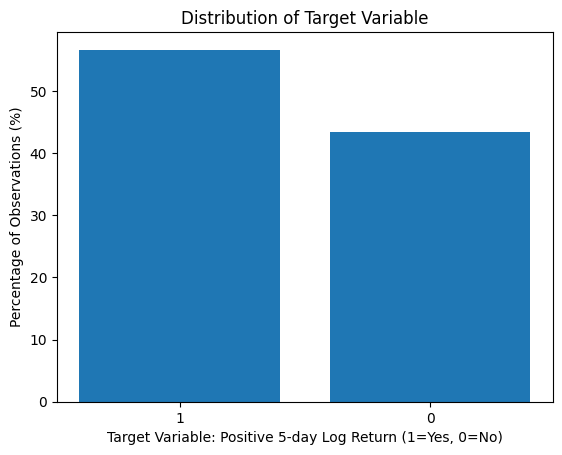

In [14]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Log Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

Let's get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/).


In [15]:
vix = yf.download("^VIX", start="2004-01-01", end="2024-03-31", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [16]:
vix.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,12.92,13.15,12.58,13.06,13.06,0
2024-03-25,13.67,13.67,13.11,13.19,13.19,0
2024-03-26,13.12,13.43,12.84,13.24,13.24,0
2024-03-27,13.13,13.34,12.66,12.78,12.78,0
2024-03-28,12.93,13.10,12.84,13.01,13.01,0


We should rename the column named "`Adj Close`" as it will clash with the one in our main DataFrame when we attempt to join them later.


In [17]:
vix.rename(columns={"Adj Close": "VIX Adj Close"}, inplace=True)

In [18]:
figure = px.line(
    vix,
    x=vix.index,
    y="VIX Adj Close",
    title="VIX Daily Adjusted Close Since 2004",
)
figure.show()

And load in Google Search Trends data for the term "recession" in the United States since 2004. This data is monthly.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


In [19]:
# load Google Trends Data, building the index from the "Month" column in the CSV which is in "YYYY-MM" format, and setting the day to the last day of the month
google_trends = pd.read_csv("GoogleTrendsData.csv", index_col="Month", parse_dates=True)
google_trends.index = google_trends.index + pd.offsets.MonthEnd()
google_trends = google_trends.rename(columns={"recession: (United States)": "recession_search_trend"})

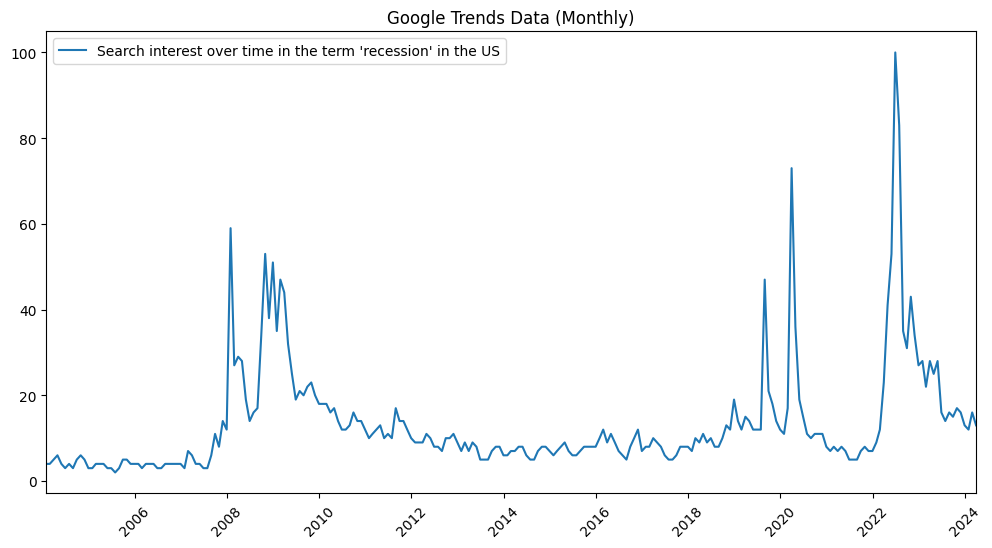

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends)
date_fmt = mdates.DateFormatter("%Y-%m")
plt.xlim(google_trends.index[0], google_trends.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.show()

But not every month-end is a trading day. Also, what value should we use for all the days in between month-ends?

In [21]:
google_trends_daily = google_trends.resample('D').asfreq()
google_trends_daily = google_trends_daily.interpolate(method='linear')

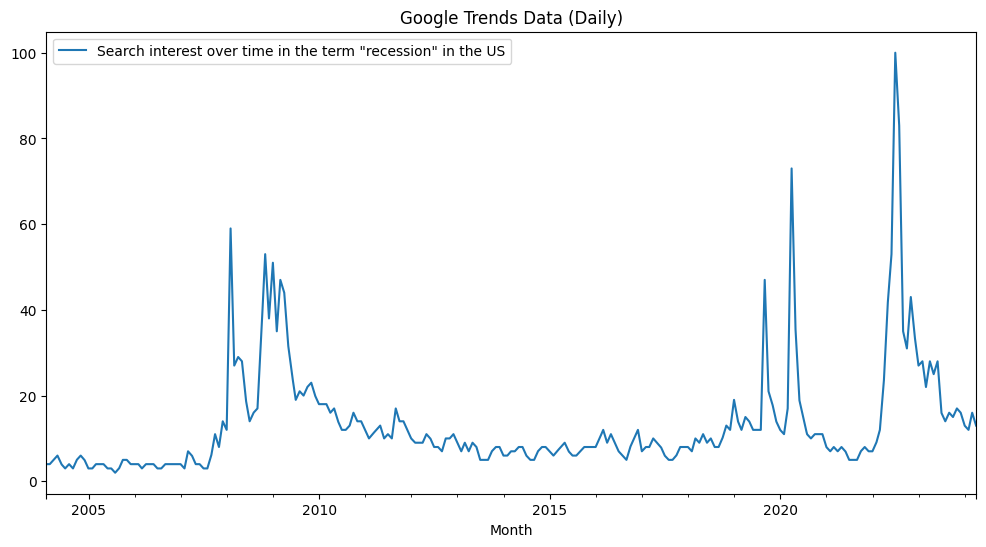

In [22]:
google_trends_daily.plot.line(title="Google Trends Data (Daily)", figsize=(12, 6)).legend(
    labels=['Search interest over time in the term "recession" in the US']
);

The shape of the chart must not have changed.


In [23]:
# TODOs:
# TODO: Introduce duplicates and missing/NaN values? (To practice data cleaning, imputing strategies, backfilling, forward-filling, etc.)

## 2. Feature Engineering and Feature Selection


### 2.1. Feature Engineering


In [24]:
# Engineer the first feature: "Internal Bar Strength" (IBS), a technical analysis indicator
data["IBS"] = (data["Close"] - data["Low"]) / (data["High"] - data["Low"])

In [25]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()

# Add Percentage Bollinger Bands
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

In [26]:
# Join the Google Trends data and technical indicators with the stock price data
data = data.join(google_trends_daily, how="left")
data = data.join(vix["VIX Adj Close"], how="left")

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2004-01-02 to 2024-03-28
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Open                    5094 non-null   float64
 1   High                    5094 non-null   float64
 2   Low                     5094 non-null   float64
 3   Close                   5094 non-null   float64
 4   Adj Close               5094 non-null   float64
 5   Volume                  5094 non-null   int64  
 6   Month                   5094 non-null   int32  
 7   Weekday                 5094 non-null   int32  
 8   ret_1d_hist             5093 non-null   float64
 9   ret_5d_hist             5089 non-null   float64
 10  ret_10d_hist            5084 non-null   float64
 11  ret_20d_hist            5074 non-null   float64
 12  tgt_ret_5d_fut          5089 non-null   float64
 13  tgt_is_pos_ret_5d_fut   5094 non-null   int64  
 14  IBS                   

Treat `Month` as a "cyclical" feature.

In [28]:
data["Month_sin"] = np.sin(2 * np.pi * data["Month"] / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Month"] / 12)

data.drop(columns=["Month"], inplace=True)

Treat `Weekday` as a "categorical" feature and one-hot-encode it.

In [29]:
data = pd.get_dummies(data, columns=["Weekday"], prefix="weekday", dtype="int32")

We do not have `recession_search_trend` data for the first month of data (January 2004) except on the last day of the month. But we know that the monthly values capture search trends over the duration of the entire month. So it would be very reasonable to backfill the entire month of January 2004 with the value from January 31st from the original monthly data.

In [30]:
data.loc["2004-01", "recession_search_trend"] = google_trends.loc["2004-01-31", "recession_search_trend"]

Some values, such as historical returns, RSI, Bollinger Bands and their indicators cannot be calculated for the first `n` days due to their "rolling" nature. We can just drop these or impute them with reasonable estimates such as their means/medians/etc. over the entire data. Normally, care must be taken when imputing with statistics from the sample itself, such that these statistics are calculated _after_ splitting the data into train/validation/test sets. But since we are dealing with ordered data, these first `n` data points all belong to the same set (the training set). In any case, for our purposes, we can simply drop them. The largest `n` is 20 (corresponding to `ret_20d_hist`).


In [31]:
data.drop(data.index[:20], inplace=True)

In [32]:
data.isna().sum()

Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
tgt_ret_5d_fut            5
tgt_is_pos_ret_5d_fut     0
IBS                       0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
bb_bbp                    0
rsi                       0
recession_search_trend    0
VIX Adj Close             0
Month_sin                 0
Month_cos                 0
weekday_0                 0
weekday_1                 0
weekday_2                 0
weekday_3                 0
weekday_4                 0
dtype: int64

By the same logic, the last 5 rows also have `NaN`s due to the calculation of "future" returns `tgt_ret_5d_fut`.


In [33]:
data.dropna(inplace=True)

Let's replace trading volumes by their logarithms, as it spans several orders of magnitude and taking its logarithm helps emphasize changes and bring out any signal hidden in the lower range.  
**Note:** For tree-based models such as Decision Trees and Random Forests, this kind of scaling is not necessary. But feature scaling becomes critically important when we use "distance-based" models.

In [34]:
data["log_volume"] = np.log(data["Volume"])

We are done engineering new features and can now drop the original price data.

In [35]:
data.drop(
    columns=["Open", "High", "Low", "Close", "Adj Close", "Volume"],
    inplace=True,
)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5069 entries, 2004-02-02 to 2024-03-21
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ret_1d_hist             5069 non-null   float64
 1   ret_5d_hist             5069 non-null   float64
 2   ret_10d_hist            5069 non-null   float64
 3   ret_20d_hist            5069 non-null   float64
 4   tgt_ret_5d_fut          5069 non-null   float64
 5   tgt_is_pos_ret_5d_fut   5069 non-null   int64  
 6   IBS                     5069 non-null   float64
 7   bb_bbm                  5069 non-null   float64
 8   bb_bbh                  5069 non-null   float64
 9   bb_bbl                  5069 non-null   float64
 10  bb_bbhi                 5069 non-null   float64
 11  bb_bbli                 5069 non-null   float64
 12  bb_bbw                  5069 non-null   float64
 13  bb_bbp                  5069 non-null   float64
 14  rsi                   

In [37]:
data.describe()

,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,tgt_ret_5d_fut,tgt_is_pos_ret_5d_fut,IBS,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,recession_search_trend,VIX Adj Close,Month_sin,Month_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,log_volume
count,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5.069000e+03,5.069000e+03,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000
mean,0.000427,0.002097,0.004185,0.008346,0.002085,0.565989,0.534112,65.190507,67.147802,63.233213,0.060761,0.054054,5.948065,0.567198,53.683015,13.290878,19.099797,-2.838770e-03,-7.572043e-03,0.186625,0.205169,0.205761,0.202210,0.200237,15.409240
std,0.010493,0.021729,0.029813,0.040486,0.021722,0.495675,0.307988,36.490915,37.643799,35.382734,0.238916,0.226147,3.644471,0.326476,11.253373,12.478947,8.747777,7.097124e-01,7.045852e-01,0.389648,0.403865,0.404296,0.401687,0.400217,1.081947
min,-0.098610,-0.185835,-0.217250,-0.251548,-0.185835,0.000000,0.000000,23.217500,24.569328,20.419952,0.000000,0.000000,1.165471,-0.452267,13.539141,2.032258,9.140000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,10.980195
25%,-0.004458,-0.009204,-0.011609,-0.013454,-0.009204,0.000000,0.259258,32.040500,32.789038,31.152674,0.000000,0.000000,3.790178,0.310053,46.019133,6.322581,13.380000,-8.660254e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,15.158428
50%,0.000633,0.002931,0.005917,0.011536,0.002917,1.000000,0.546873,57.274000,58.749715,54.721044,0.000000,0.000000,5.052307,0.622857,54.080883,9.225806,16.549999,-2.449294e-16,-1.836970e-16,0.000000,0.000000,0.000000,0.000000,0.000000,15.703898
75%,0.005891,0.014858,0.021953,0.032931,0.014828,1.000000,0.818179,90.399500,93.205837,87.412764,0.000000,0.000000,7.015371,0.832430,61.812445,14.931034,22.129999,8.660254e-01,5.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,16.075052
max,0.120547,0.192308,0.223935,0.299115,0.192308,1.000000,1.000000,146.183501,148.369194,144.631724,1.000000,1.000000,32.354816,1.349959,85.413254,100.000000,82.690002,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,18.012264


### 2.2. Correlation Analysis


Correlation analysis can be a form of approximate and early feature importance analysis. Features that are highly correlated with each other (but not with the target variable) can be a sign of multicollinearity problems, which means they might not add much additional information in predicting the target. Looking at the correlation matrix heatmap can be helpful in identifying such features.


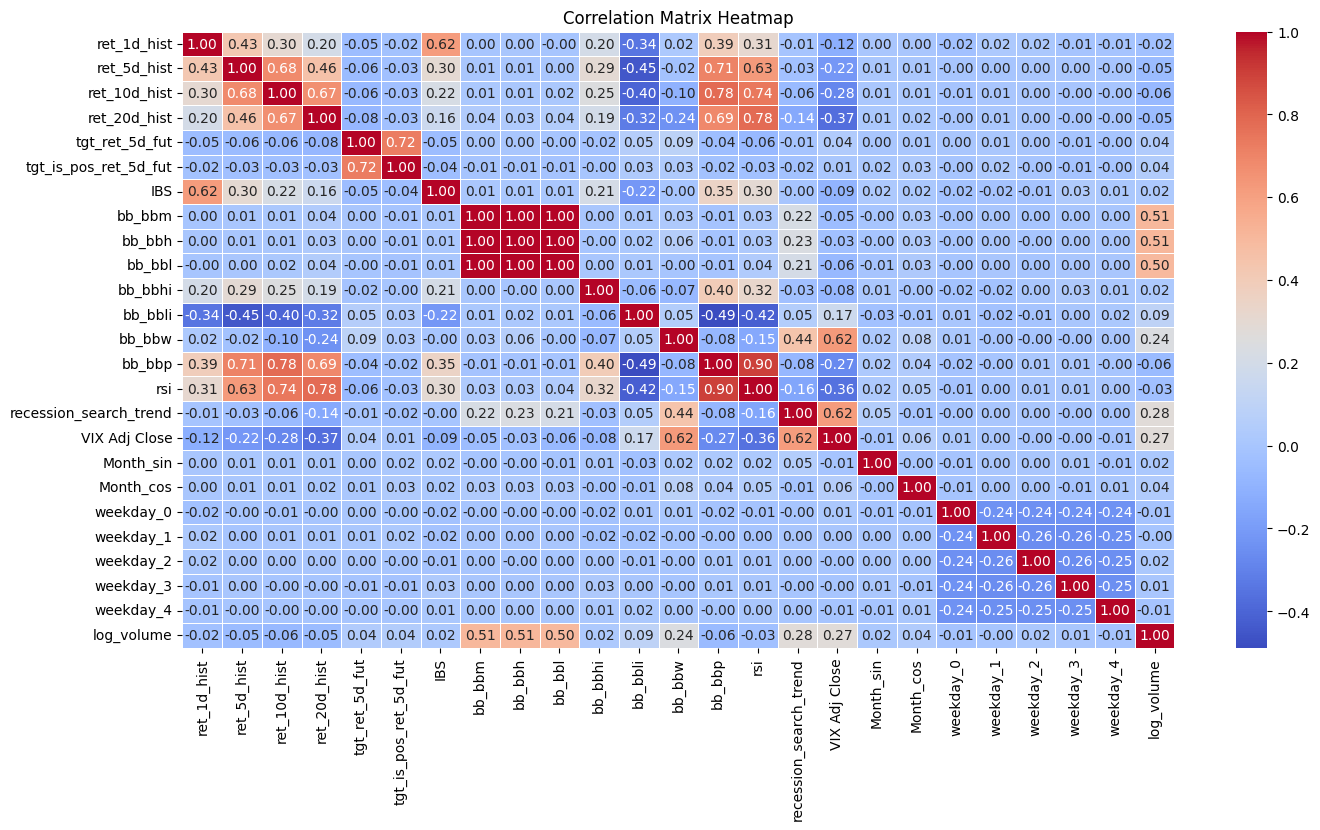

In [41]:
def plot_corr_mtx(data: pd.DataFrame):
    plt.figure(figsize=(16, 8))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

plot_corr_mtx(data)

In [ ]:
# Drop bb_bbh and bb_bbl due to their high correlation with bb_bbm
data.drop(columns=["bb_bbh", "bb_bbl"], inplace=True)

# Also drop Bollinger Band Percentage (bb_bbp) due to its high correlation with RSI
data.drop(columns=["bb_bbp"], inplace=True)

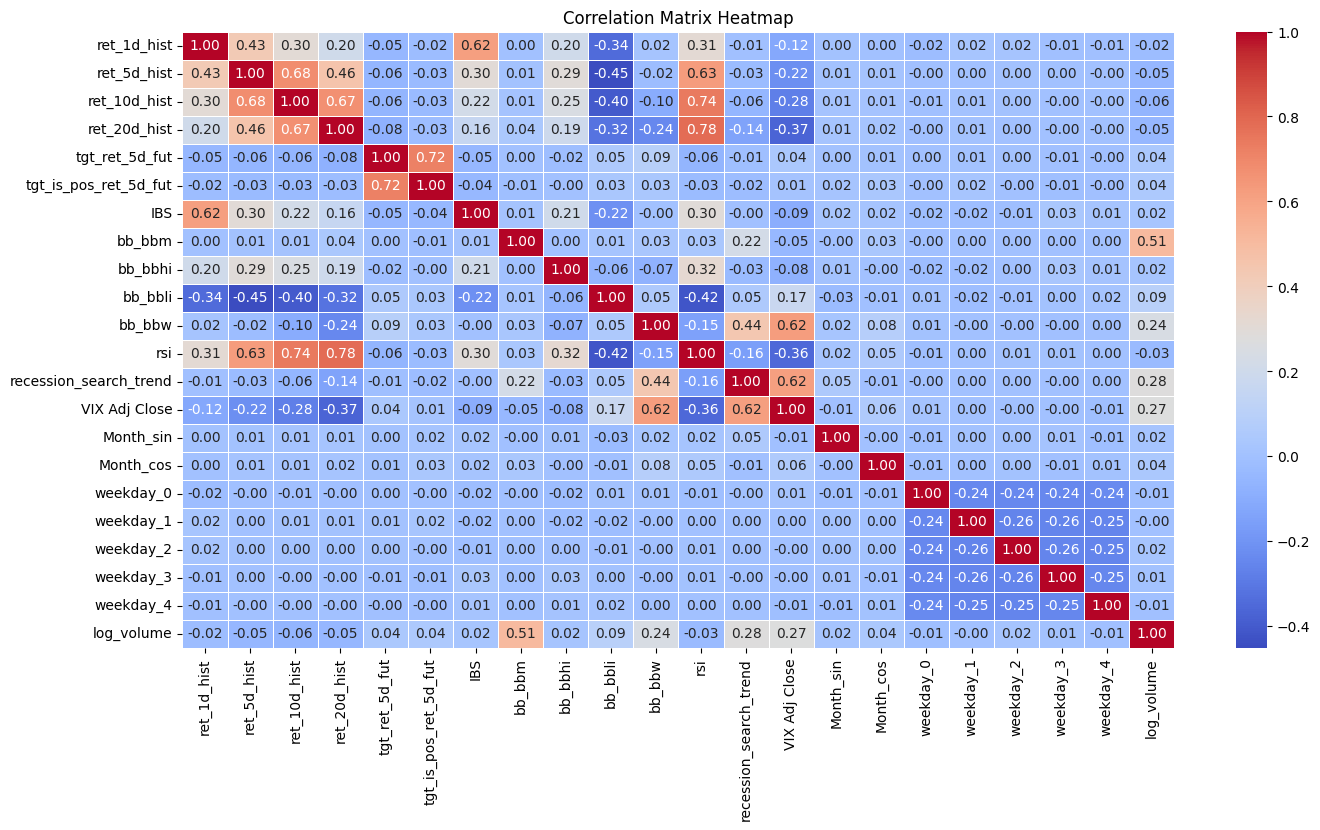

In [45]:
plot_corr_mtx(data)

Features that are highly correlated (negatively or positively) with the target variable are likely more important. Which variables are correlated more than 4% (in either direction) with the boolean target variable denoting whether 5-day future returns are positive?


In [46]:
data.corr()["tgt_is_pos_ret_5d_fut"].abs().sort_values(ascending=False)

tgt_is_pos_ret_5d_fut     1.000000
tgt_ret_5d_fut            0.722078
IBS                       0.044293
log_volume                0.043164
Month_cos                 0.034075
ret_10d_hist              0.032284
bb_bbw                    0.031639
ret_5d_hist               0.031627
bb_bbli                   0.031542
rsi                       0.026672
ret_20d_hist              0.025091
ret_1d_hist               0.022092
recession_search_trend    0.021242
weekday_1                 0.020079
Month_sin                 0.016087
weekday_3                 0.014012
bb_bbm                    0.009908
VIX Adj Close             0.009806
weekday_4                 0.004455
bb_bbhi                   0.002207
weekday_2                 0.001306
weekday_0                 0.000435
Name: tgt_is_pos_ret_5d_fut, dtype: float64

It is time to split our data, temporally, into the train + validation and test sets. We will use the first 75% of the data to train and optimize our model, and the last 25% for the test set (to evaluate the performance of the model).  
Before we perform the split, let's take a look at the distribution of the target variable in each set.


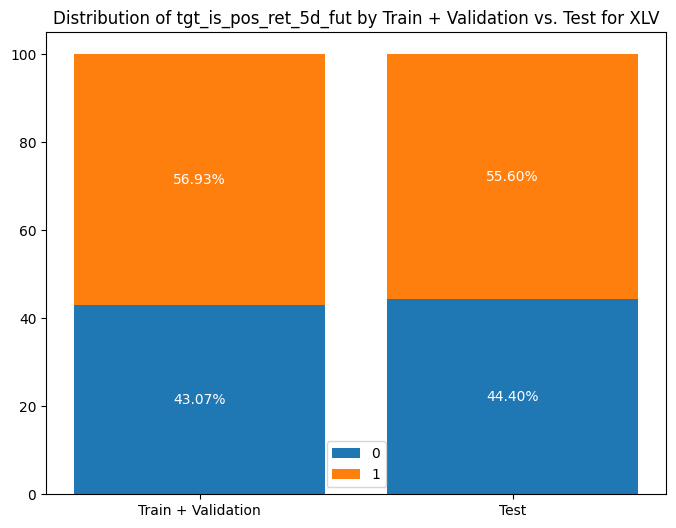

In [47]:
TRAIN_VAL_PROP = 0.75
TEST_PROP = 1 - (TRAIN_VAL_PROP)

total_length = len(data)
train_val_length = int(TRAIN_VAL_PROP * total_length)
test_length = int(TEST_PROP * total_length)

train_val_data = data.iloc[:train_val_length]
test_data = data.iloc[train_val_length:]
train_val_counts = train_val_data["tgt_is_pos_ret_5d_fut"].value_counts(normalize=True) * 100
test_counts = test_data["tgt_is_pos_ret_5d_fut"].value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_counts[0], test_counts[0]]
one_counts = [train_val_counts[1], test_counts[1]]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create bar chart
ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )

# Set title and labels
ax.set_title("Distribution of tgt_is_pos_ret_5d_fut by Train + Validation vs. Test for XLV")
ax.legend()

plt.show()

In [48]:
# TODOs:
# TODO: Add a similar visual for tgt_ret_5d_fut (violin, boxplot, etc.) if doing regression

In [49]:
def split(df, min_date, max_date, train_val_prop, test_prop):
    assert train_val_prop + test_prop == 1, "Proportions must add up to 1"

    df = df.sort_index()

    # Filter dataframe between min and max dates
    df = df[(df.index >= min_date) & (df.index <= max_date)]

    # Calculate the number of samples for each split
    split_point = int(len(df) * train_val_prop)

    # Create the 'split' column
    df["split"] = "test"
    df.iloc[:split_point, df.columns.get_loc("split")] = "train_val"

    return df

In [50]:
data_w_splits = split(
    data,
    min_date=data.index.min(),
    max_date=data.index.max(),
    train_val_prop=TRAIN_VAL_PROP,
    test_prop=TEST_PROP,
)

In [51]:
data_w_splits.split.value_counts()

split
train_val    3801
test         1268
Name: count, dtype: int64

In [52]:
data_w_splits.split.value_counts() / len(data_w_splits)

split
train_val    0.749852
test         0.250148
Name: count, dtype: float64

It is roughly the 75%-25% we aimed for. Now we create our master list of features (independent variables) and prediction targets (dependent variables) and perform the split.


In [53]:
features = data_w_splits.drop(data.filter(regex="^tgt_").columns, axis=1, inplace=False)
targets = data_w_splits.filter(regex="^tgt_", axis=1).join(data_w_splits["split"])

X_train_val = features[features.split == "train_val"].drop(columns=["split"], inplace=False)
X_test = features[features.split == "test"].drop(columns=["split"], inplace=False)

y_train_val = targets[targets.split == "train_val"]["tgt_is_pos_ret_5d_fut"]
y_test = targets[targets.split == "test"]["tgt_is_pos_ret_5d_fut"]

In [54]:
# TODOs
# TODO: Practice more feature importance (feature permutation, etc.) here with a simple model that is NOT our final model (e.g. a cross-validated LinearRegression)? Or just do it later after training our actual model?
# TODO: Investigate outliers; add practice questions for scalers from sklearn.preprocessing (e.g. MinMaxScaler, StandardScaler, RobustScaler, etc.) - UPDATE: We do NOT need to scale the data for tree-based (as opposed to distance-based) models like Random Forest. Perhaps make a question out of it.
# TODO: Consider choosing a different target variable in which the data is imbalanced so that we can practice using SMOTE, oversampling, undersampling or other techniques to balance the data
# TODO: Consider adding features (even if I have to make them up) that allows the student to practice handling or answer questions about:
# - Handling values never seen in training
# - Data leakage (e.g. when scaling data in preprocessing, or when using future data to predict past data, or when using the target variable indirectly in the features)
# - backfilling/forwardfilling (e.g. GDP data is announced retrospectively) - we already did this with `google_trends`
# TODO: Export the starting data (after manually messing it up where necessary) as well as the final (cleaned, preprocessed) data to a CSV file.

## 3. Model Training and Tuning


Inspect the learning curves for a RandomForestClassifier with a max_depth of 10, using 10%, 20%, 30%,... , and 100% of the training data, with 5-fold cross-validation.


In [55]:
train_sizes = np.linspace(0.1, 1.0, 10)
model = RandomForestClassifier(max_depth=10, random_state=42)

In [56]:
def plot_learning_curves(train_sizes, train_scores, test_scores, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title("Learning Curves")
    axs.legend(loc="center left")
    axs.grid(True)

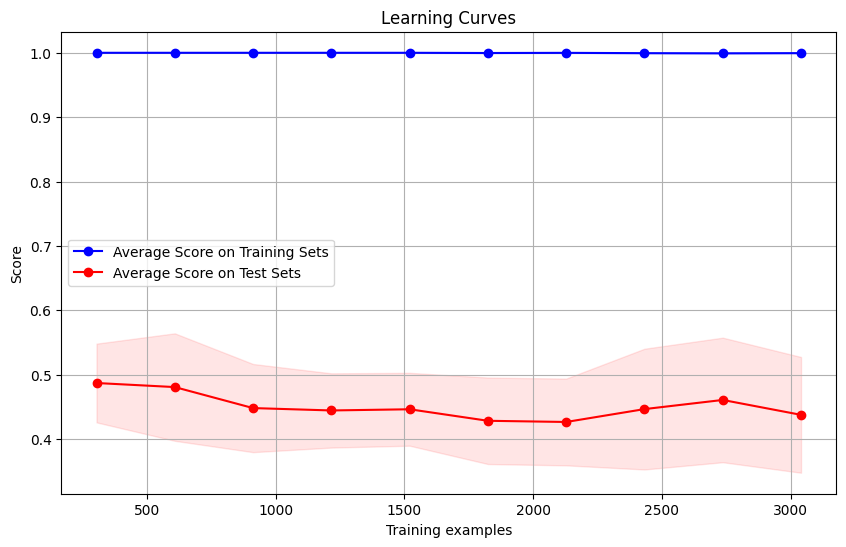

In [76]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
)

plot_learning_curves(train_sizes, train_scores, test_scores, axs)

plt.show()

We observe overfitting. How do we address this? Experiment with lower and higher values for `max_depth` to see how the plots change.


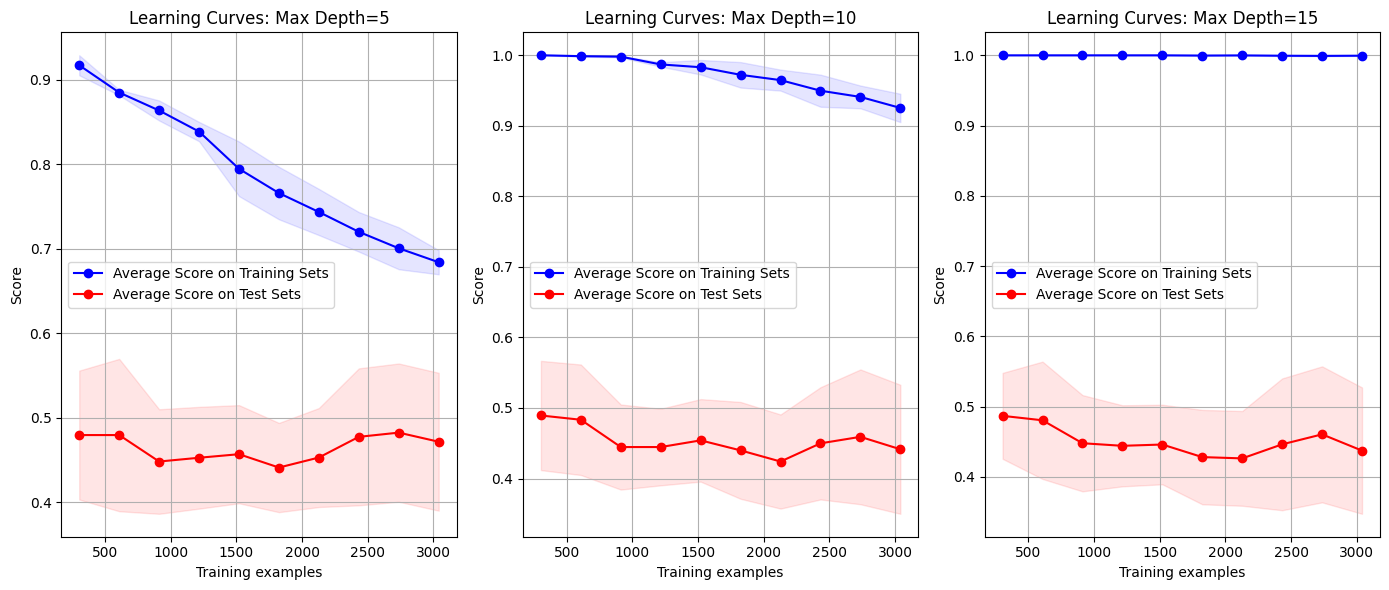

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [5, 10, 15]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, axs[i])
    axs[i].set_title(axs[i].title.get_text() + f": Max Depth={max_depth}")

plt.tight_layout()
plt.show()

There are other hyperparameters as well, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100).
Let's use GridSearch to find the optimal combination from the list below:


In [78]:
grid = {
    "max_depth": range(2, 6),
    # "min_samples_split": range(2, 6),
    "min_samples_leaf": range(1, 5),
    "n_estimators": [50, 75, 100, 125, 150],
}

search = GridSearchCV(model, grid, scoring="accuracy", cv=5, n_jobs=-1)

search.fit(X_train_val, y_train_val);

In [79]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.249195,0.007007,0.005300,0.001966,2,3,150,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.453351,0.361842,0.569737,0.569737,0.568421,0.504618,0.084339,1
4,0.259459,0.026166,0.004658,0.000748,2,1,150,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.453351,0.361842,0.569737,0.569737,0.568421,0.504618,0.084339,1
9,0.269907,0.018682,0.006140,0.002356,2,2,150,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.453351,0.361842,0.569737,0.569737,0.568421,0.504618,0.084339,1
3,0.222179,0.011984,0.004699,0.001693,2,1,125,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.454665,0.360526,0.569737,0.569737,0.568421,0.504617,0.084628,4
18,0.207136,0.013496,0.004363,0.000805,2,4,125,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.454665,0.360526,0.569737,0.569737,0.568421,0.504617,0.084628,4
19,0.253505,0.020235,0.004494,0.000345,2,4,150,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.453351,0.360526,0.569737,0.569737,0.568421,0.504354,0.084785,6
8,0.214855,0.016420,0.004688,0.001180,2,2,125,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.454665,0.359211,0.569737,0.569737,0.568421,0.504354,0.085076,7
13,0.215141,0.008608,0.004258,0.000996,2,3,125,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.454665,0.359211,0.569737,0.569737,0.568421,0.504354,0.085076,7
12,0.188448,0.022133,0.004305,0.001175,2,3,100,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.452037,0.357895,0.569737,0.569737,0.568421,0.503565,0.085836,9
7,0.169065,0.019343,0.004031,0.001009,2,2,100,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.452037,0.357895,0.569737,0.569737,0.568421,0.503565,0.085836,9


Looking at the results of GridSearch, which parameters yield the highest scores? And which parameters do not seem to have any effect on the score?

<details>
<summary>Show Answers</summary>

The best combination is `max_depth=2`, `min_samples_leaf=1` and `n_estimators=100` and for it makes no difference which `min_samples_split` value we choose to go along with these.

</details>


In [80]:
search.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 150}

## 4. Model Evaluation and Interpretation


It is time to train our model on the training data with the optimal set of hyperparameters we have found, and evaluate its performance on the test set.


In [81]:
clf = RandomForestClassifier(max_depth=2, min_samples_leaf=1, n_estimators=150, random_state=42)
clf.fit(X_train_val, y_train_val)
clf.score(X_test, y_test)

0.5583596214511041

In [82]:
y_pred = clf.predict(X_test)
evaluation = {
    "accuracy" : accuracy_score(y_test, y_pred),
    "precision" : precision_score(y_test, y_pred),
    "recall" : recall_score(y_test, y_pred),
    "f1" : f1_score(y_test, y_pred)
}
display(evaluation)

{'accuracy': 0.5583596214511041,
 'precision': 0.5573122529644269,
 'recall': 1.0,
 'f1': 0.7157360406091371}

What do the precision and recall scores mean?
<details>
<summary>Show Answers</summary>

The Precision Score tells us that 55.6% of the predicted positives were true positives and the remaining 44.4% were false positives.  
The Recall Score shows that 100% of all actual positives were predicted (i.e. there were no false negatives).

</details>

In [83]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       563
           1       0.56      1.00      0.72       705

    accuracy                           0.56      1268
   macro avg       0.78      0.50      0.36      1268
weighted avg       0.75      0.56      0.40      1268



In [84]:
confusion_matrix(y_test, y_pred)

array([[  3, 560],
       [  0, 705]])

### 4.2. Revisiting Feature Importance

Now that we have a fully trained, optimized and evaluated model, we can revisit feature importance.

In [85]:
feat_imp = pd.Series(clf.feature_importances_, index=X_train_val.columns)
display(feat_imp.sort_values(ascending=False))

recession_search_trend    0.172099
bb_bbm                    0.138739
log_volume                0.106453
IBS                       0.080467
ret_5d_hist               0.073135
ret_10d_hist              0.070756
bb_bbw                    0.062825
VIX Adj Close             0.057469
rsi                       0.057440
ret_1d_hist               0.050277
ret_20d_hist              0.045585
Month_cos                 0.042984
Month_sin                 0.027927
bb_bbli                   0.004510
weekday_0                 0.002754
weekday_4                 0.002705
weekday_1                 0.002190
weekday_2                 0.001687
bb_bbhi                   0.000000
weekday_3                 0.000000
dtype: float64

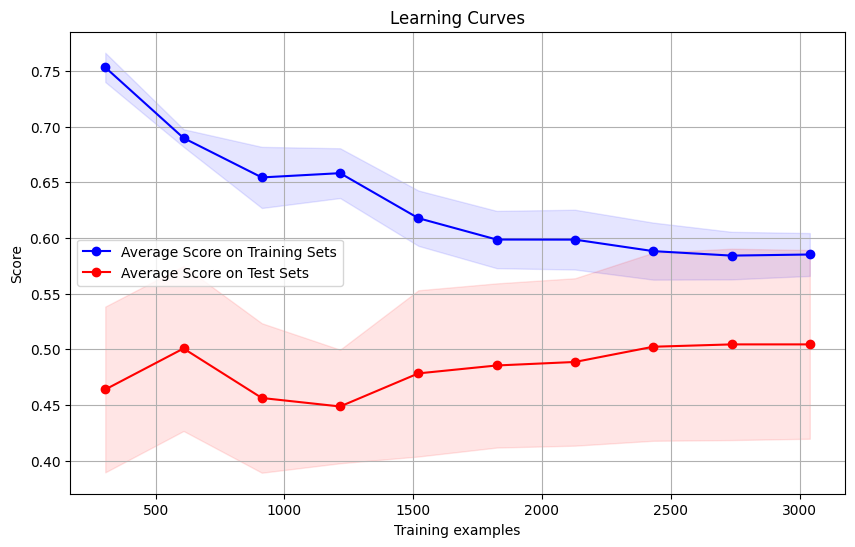

In [86]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
)

plot_learning_curves(train_sizes, train_scores, test_scores, axs)

plt.show()

In [87]:
# TODOs:
# TODO: Still room for improving the score? Would PCA help?

# 5. Drift Analysis
